# REGRESSION ANALYSIS

The goal of a regression analysis is to estimate the relationship between *dependent variables* and  *independent variables*.

Given a set of observed data points $X = {x_0, x_1, ..., x_n}$ with corresponding output values $Y = { y_0, y_1, ..., y_n}$, we want to relate Y to X through a *function* $y = f(x, \omega)$, where $\omega$ are parameters of the model to be determined by the analysis.

## A Synthetic Experiment

Suppose we have an experiment where some physical process generates a peak signal of a certain height at certain scale (energy, frequency, wavelength). As all experiments, the signal is affected by a background noise, that might be determined by specific physical processes, plus random noise from unknown instrumental or environmental uncertainties.

We consider an experiment with the following characteristics:

- Signal: 1 Gaussian peak
- Deterministic Background 1: exponential or linear
- Threshold jump: arctan curve
- Random Gaussian noise

All these components are additive to the whole raw data that is collected at the end of the experiment.


We use the support material for the course. Let us load the code: `Supplemental_Material/Synth_dataset.py`

In [1]:
import sys
sys.path.append('../../supplemental_material')
import synth_dataset as sd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define color-blind-friendly palette
hex1 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
hex1_inverted = hex1[::-1]
colors1=[mcolors.to_rgb(i) for i in hex1]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [1]:
# array of x values
x = np.linspace(0,1,100)
# produce gaussian peak signals
signal = sd.random_peaks(x,peaks_range=[1,2],c = 0.10, roi_position=[0.45,0.55],ph_min = 0.1, ph_max = 0.5, edge_tol=0.2,method=2)
# produce an exponential background 
background = sd.exponential_bg(len(x))
# produce threshold jump
threshold = sd.random_arctan_curve(len(x),itx_min=0.1,center_min=0.45,center_max=0.55,x_scale_min=0.05, x_scale_max=0.1)

NameError: name 'np' is not defined

In [2]:
# add random noise to generate the raw signal
snr = 35
raw = sd.add_noise(snr=snr, signal = signal + background + threshold)

NameError: name 'sd' is not defined

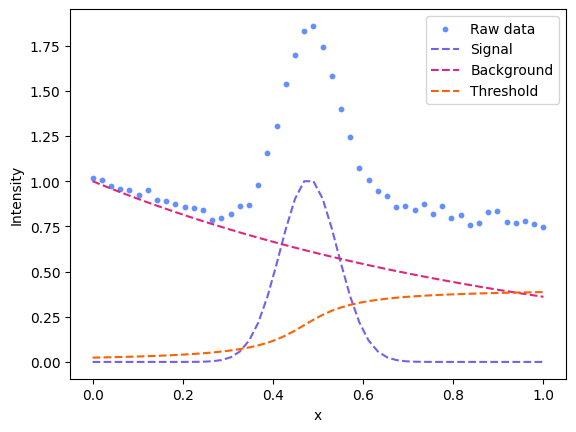

In [4]:
# plot the data
plt.scatter(x,raw,label='Raw data',color=colors1[0],s=10)
plt.plot(x,signal,label='Signal',ls='--',color=colors1[1])
plt.plot(x,background,label='Background',ls='--',color=colors1[2])
plt.plot(x,threshold,label='Threshold',ls='--',color=colors1[3])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## Fitting the background

Suppose we are able to run the same experiment without a signal. For instance, we remove the material from a spectroscopy experiment, and we take a measurement of the background. This is not always possible, but for the sake of the lecture let us assume it is.

We then generate a background-only measurement:

In [5]:
background_only = sd.add_noise(snr=snr, signal = background + threshold)

Given our prior knowledge of the experiment, and our observation of the raw data, we know that:

- [observation] The background is a fairly smooth, monotone decreasing function                                       
- [prior knowledge] Roughly after the first peak, there is a threshold jump which manifests as an arctan function         
- [observation] Scatter in the data indicates some random noise given by instrumental or environmental disturbances   

``[blackboard] Maximum Likelihood Criterion and Loss Functions``  (cfr. Section 3 of Bishop, Section 5 of Prince)



As seen on the blackboard, we can devise a family of basis functions 

$$ 
y(\underline x, \underline \omega) = \omega_0 + \sum_{j=1}^{M-1} \omega_j \phi_j(\underline x) = \underline \omega^T \underline \phi (\underline x)
$$

to model complicated signals, and as long as the model is linear in the parameters $\underline\omega$, we can use the generalized least squares method.

The background might be represented by an exponential, plus the arctan is also non-linear in parameters. Nevertheless, we can hope that a family of linear functions in the parameters can correctly approximate this behaviour.

### Polynomial Fit

Let us start from a simple ansatz: the basis functions are polynomials

$$
y^i(x^i,\underline \omega) = \omega_0 + \omega_1 x^i + ... + \omega_{M-1} x^i = \sum_{j=1}^{M-1} \omega_j (x^i)^j
$$

We can therefore implement the closed solution found before (see blackboard derivation)

In [6]:
prediction = []
weights = []
M = 20  #Maximum number of basis functions
for i in range(M):
    phi = np.zeros((i,len(x)))
    for j in range(i):
        phi[j] = x**j
    temp = np.linalg.inv(phi@phi.T)@phi@background_only
    weights.append(temp)
    prediction.append(temp.T@phi)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


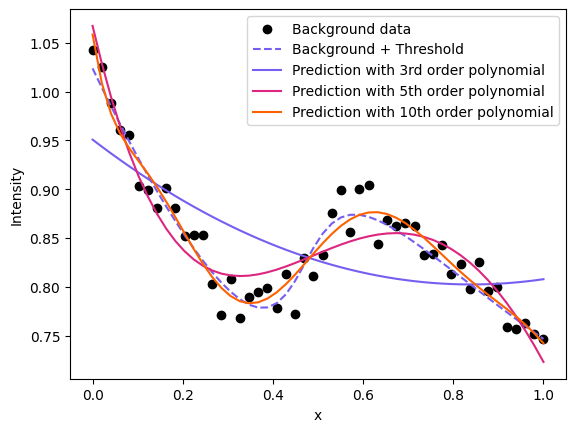

In [7]:
plt.scatter(x,background_only,label='Background data',color='black')
plt.plot(x,background+threshold,label='Background + Threshold',ls='--',color=colors1[1])
plt.plot(x,prediction[3],label='Prediction with 3rd order polynomial',color=colors1[1])
plt.plot(x,prediction[5],label='Prediction with 5th order polynomial',color=colors1[2])
plt.plot(x,prediction[9],label='Prediction with 10th order polynomial',color=colors1[3])
#plt.plot(x,prediction[15],label='Prediction with 15th order polynomial',color=colors1[4])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

We can see that low order polynomials do not capture the arctan, but high order polynomials try to fit the random noise - they overfit the data. These models will tend to generalize poorly to new sets of data with the same characteristics. 


### Training and Test datasets


Let us see this by devising a `test` dataset, which is just a new realization of the noise on top of the background, and evaluate the root mean square error 

$$
E_{\rm RMS} = \sqrt{2 E(\omega^*)/N}
$$

where $E(\omega^*)$ is the error function evaluated on the minimum $\omega^*$ and $N$ is the number of $x$ values

In [8]:
# RMS error function for the training set
E = np.sqrt(2*np.sum((background_only-prediction)**2,axis=1)/len(x))
# add noise to the background+threshold to generate the test set
background_test = sd.add_noise(snr=snr, signal = background+threshold)
# RMS error function for the test set
E_test = np.sqrt(2*np.sum((background_test-prediction)**2,axis=1)/len(x))
# RMS error function where we take the exact prediction
E_baseline = np.sqrt(2*np.sum((background_test-(background+threshold))**2)/len(x))

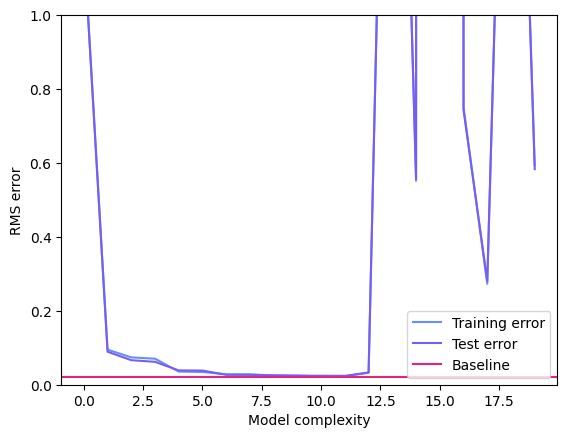

In [9]:
plt.plot(range(M),E,label='Training error',color=colors1[0])
plt.plot(range(M),E_test,label='Test error',color=colors1[1])
plt.axhline(E_baseline,label='Baseline',color=colors1[2])
plt.xlabel('Model complexity')
plt.ylabel('RMS error')
plt.ylim(0,1)
plt.legend()

In [10]:
print('The best model is a polynomial of %dth order and has RMS error value %f' %(np.argmin(E_test)+1,np.min(E_test)))

The best model is a polynomial of 12th order and has RMS error value 0.024050


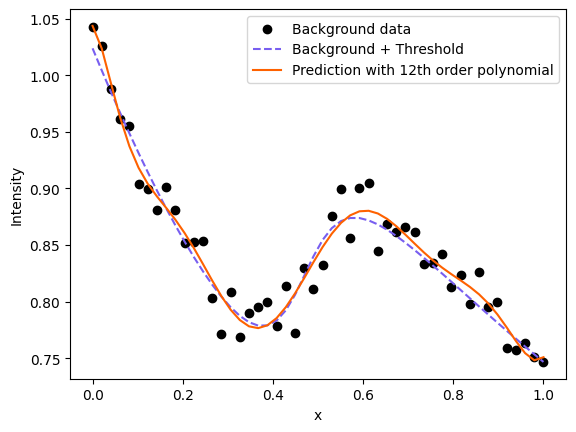

In [11]:
plt.scatter(x,background_only,label='Background data',color='black')
plt.plot(x,background+threshold,label='Background + Threshold',ls='--',color=colors1[1])
plt.plot(x,prediction[np.argmin(E_test)],label='Prediction with %dth order polynomial'%(np.argmin(E_test)+1),color=colors1[3])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

While this is close to the right curve, it seems clear that the model is fitting some noise as well. Let us look closer to the minimum

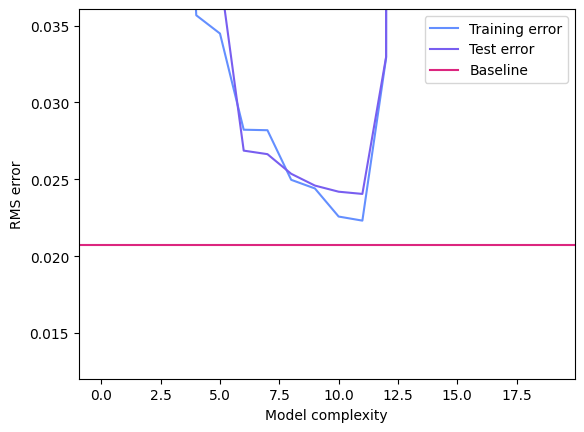

In [12]:
plt.plot(range(M),E,label='Training error',color=colors1[0])
plt.plot(range(M),E_test,label='Test error',color=colors1[1])
plt.axhline(E_baseline,label='Baseline',color=colors1[2])
plt.xlabel('Model complexity')
plt.ylabel('RMS error')
plt.ylim(np.min(E_test)-np.min(E_test)/2,np.min(E_test)+np.min(E_test)/2)
plt.legend()

Observations:

- The model might improve below the baseline. This clearly means that we are fitting noise. This would be alleviated with a larger dataset, for instance taking the same measurement multiple times. This is a luxury that frequently is not present. Besides, the baseline is not really available in general. Hence, this indicates a weak point of the analysis.
- The test error might be slightly below the training error. This is just a limitation of this particular example.

#### A note on performance

Performance of a model for a given problem is affected by three main things:

- Inherent uncertainty in the task [noise]
- amount of training data [variance]
- choice of model [bias]

Counterintuitively, adding more training data and increasing complexity of the model does not always solve the problem (bias-variance tradeoff). [cfr. section 3.2 of Bishop and 8.3 of Prince]

### Regularization

Another somewhat undesirable point is that higher order polynomials are completely out of control. This is made evident by tabulating the weights:

In [13]:
from tabulate import tabulate

weights_table = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        if j < i:
            weights_table[i,j] = weights[i][j]
        else:
            weights_table[i,j] = 0

headers = [f'M={j}' for j in range(M-1)]

print(tabulate(weights_table.T, headers=headers, tablefmt='grid'))

+----+----------+-----------+-----------+----------+----------+------------+------------+------------+-------------+-------------+---------------+---------------+-------------------+---------------+-----------------+---------------+---------------+-------------------+---------------+
|    |      M=0 |       M=1 |       M=2 |      M=3 |      M=4 |        M=5 |        M=6 |        M=7 |         M=8 |         M=9 |          M=10 |          M=11 |              M=12 |          M=13 |            M=14 |          M=15 |          M=16 |              M=17 |          M=18 |
+====+==========+===========+===========+==========+==========+============+============+============+=============+=============+===============+===============+===================+===============+=================+===============+===============+===================+===============+
|  0 | 0.845017 |  0.916468 |  0.95079  |  1.05138 |  1.06724 |   1.03285  |   1.03055  |    1.051   |     1.05846 |     1.04686 |      1.04356  

We can see that even the best model has very large values of the weights. We would like to see that higher order polynomials do not improve the fit, i.e. saturate the goodness of the model, instead they get worse.

A way out is regularizing the values of the weights. [for more details on regularization cfr. section 9 of Prince]

This is done by adding a term in the error function to penalize weights from obtaining arbitrarily large values:

$$ \tilde{E}(\underline{\omega}) = \frac 12 \sum_{i=1}^{n} \left[y_i - \underline{\omega}^T \phi(x_i)\right]^2 + \frac{\lambda}{2} \underline{\omega}^T\underline{\omega}$$

where $\lambda$ needs to be tuned empirically. The solution changes to

$$ \underline{\omega}^{*} = \left(\lambda \mathbb{I} + \Phi^T\Phi\right)^{-1}\Phi^T \underline{y} $$

Let us now implement it.

In [14]:
prediction_lambda = []
weights_lambda = []
lam = 1e-4
M = len(x)
for i in range(M):
    phi = np.zeros((i,len(x)))
    for j in range(i):
        phi[j] = x**j
    temp = np.linalg.inv(lam*np.identity(i)+phi@phi.T)@phi@background_only 
    weights_lambda.append(temp)
    prediction_lambda.append(temp.T@phi)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


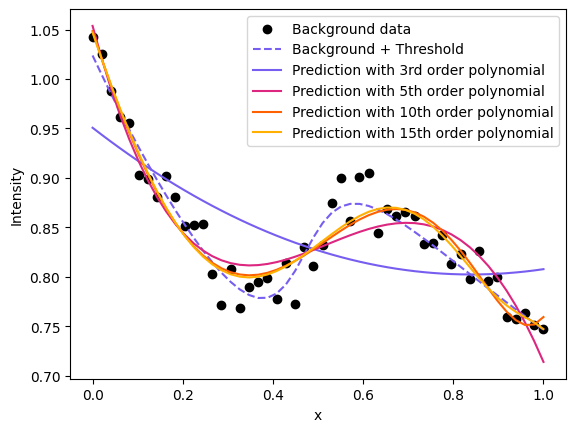

In [15]:
plt.scatter(x,background_only,label='Background data',color='black')
plt.plot(x,background+threshold,label='Background + Threshold',ls='--',color=colors1[1])
plt.plot(x,prediction_lambda[3],label='Prediction with 3rd order polynomial',color=colors1[1])
plt.plot(x,prediction_lambda[5],label='Prediction with 5th order polynomial',color=colors1[2])
plt.plot(x,prediction_lambda[10],label='Prediction with 10th order polynomial',color=colors1[3])
plt.plot(x,prediction_lambda[14],label='Prediction with 15th order polynomial',color=colors1[4])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

Let us calculate RMS errors again

In [16]:
E = np.sqrt(2*np.sum((background_only-prediction_lambda)**2,axis=1)/len(x))
background_test = sd.add_noise(snr=snr, signal = background+threshold)
E_test = np.sqrt(2*np.sum((background_test-prediction_lambda)**2,axis=1)/len(x))
E_baseline= np.sqrt(2*np.sum((background+threshold-background_test)**2)/len(x))

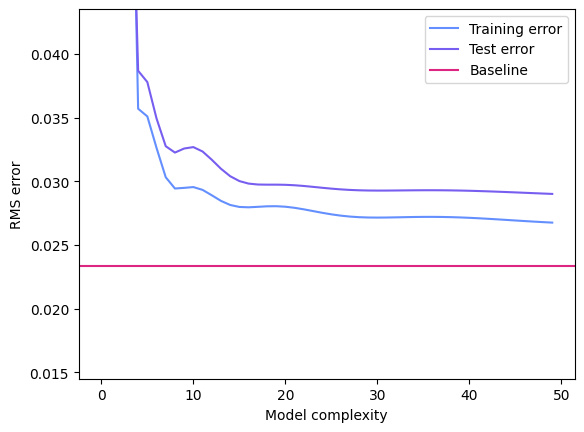

In [17]:
plt.plot(range(M),E,label='Training error',color=colors1[0])
plt.plot(range(M),E_test,label='Test error',color=colors1[1])
plt.axhline(E_baseline,label='Baseline',color=colors1[2])
plt.xlabel('Model complexity')
plt.ylabel('RMS error')
plt.ylim(np.min(E_test)-np.min(E_test)/2,np.min(E_test)+np.min(E_test)/2)
plt.legend()

We see now that we obtained the desired effect of regularizing as a function of model complexity.

In [18]:
print('The best model is a polynomial of %dth order and has RMS error value %f' %(np.argmin(E_test)+1,np.min(E_test)))

The best model is a polynomial of 50th order and has RMS error value 0.029008


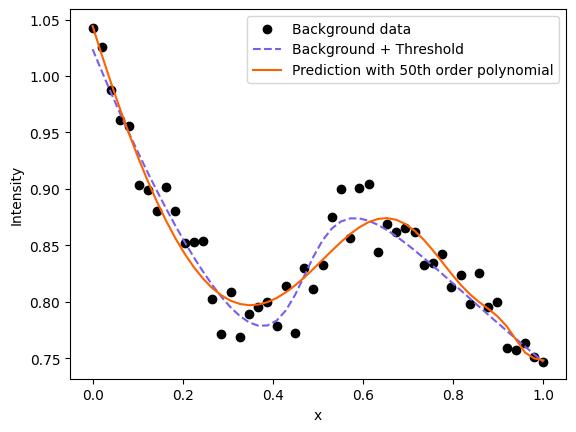

In [19]:
plt.scatter(x,background_only,label='Background data',color='black')
plt.plot(x,background+threshold,label='Background + Threshold',ls='--',color=colors1[1])
plt.plot(x,prediction_lambda[np.argmin(E_test)],label='Prediction with %dth order polynomial'%(np.argmin(E_test)+1),color=colors1[3])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

In [20]:
from tabulate import tabulate

weights_table = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        if j < i:
            weights_table[i,j] = weights_lambda[i][j]
        else:
            weights_table[i,j] = 0

headers = [f'M={j}' for j in range(M-1)]

print(tabulate(weights_table.T, headers=headers, tablefmt='grid'))

+----+----------+-----------+-----------+----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+-------------+------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+------------+------------+-------------+-------------+------------+
|    |      M=0 |       M=1 |       M=2 |      M=3 |       M=4 |       M=5 |      M=6 |       M=7 |       M=8 |       M=9 |      M=10 |        M=11 |      M=12 |      M=13 |      M=14 |       M=15 |       M=16 |       M=17 |       M=18 |       M=19 |       M=20 |       M=21 |       M=22 |       M=23 |       M=24 |       M=25 |        M=26 |       M=27 |     

## Fitting the raw data

Armed with some understanding on how to use the basis function, we can now try to fit the whole raw data take. We know that now the model has to fit two additional Gaussian peaks on top of the background. Let's start with the same model as before. 

In [21]:
prediction = []
weights = []
lam = 1e-5
M = len(x)
for i in range(M):
    phi = np.zeros((i,len(x)))
    for j in range(i):
        phi[j] = x**j
    temp = np.linalg.inv(lam*np.identity(i)+phi@phi.T)@phi@raw
    weights.append(temp)
    prediction.append(temp.T@phi)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [22]:
E = np.sqrt(2*np.sum((raw-prediction)**2,axis=1)/len(x))
raw_test = sd.add_noise(snr=20, signal = signal+background+threshold)
E_test = np.sqrt(2*np.sum((raw_test-prediction)**2,axis=1)/len(x))
E_baseline = np.sqrt(2*np.sum((background+threshold+signal-raw_test)**2)/len(x))

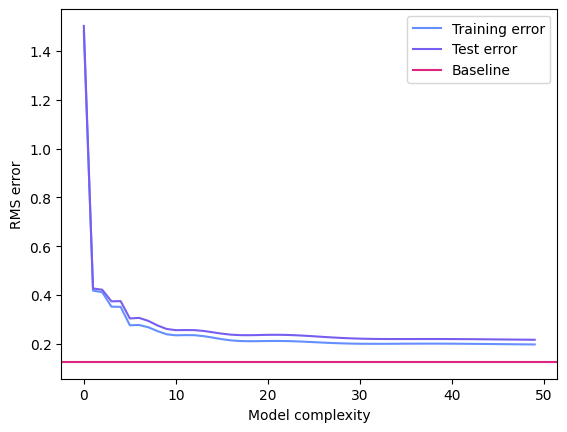

In [23]:
plt.plot(range(M),E,label='Training error',color=colors1[0])
plt.plot(range(M),E_test,label='Test error',color=colors1[1])
plt.axhline(E_baseline,label='Baseline',color=colors1[2])
plt.xlabel('Model complexity')
plt.ylabel('RMS error')
#plt.yscale('log')
plt.legend()

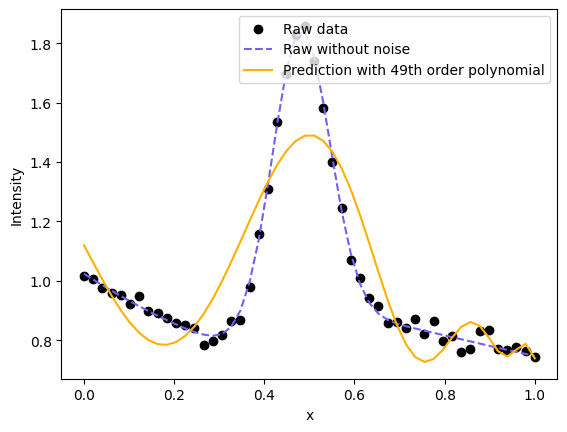

In [24]:
plt.scatter(x,raw,label='Raw data',color='black')
plt.plot(x,background+threshold+signal,label='Raw without noise',ls='--',color=colors1[1])
plt.plot(x,prediction[np.argmin(E)],label='Prediction with %dth order polynomial'%np.argmin(E),color=colors1[4])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

In [25]:
print('The best model is a polynomial of %dth order and has RMS error value %f' %(np.argmin(E_test)+1,np.min(E_test)))

The best model is a polynomial of 50th order and has RMS error value 0.216688


Clearly this set of basis functions is not good enough to fit the data. We can add a series of Gaussian peaks to the model to give it more complexity.

In [26]:
prediction = []
weights = []
lam = 1e-2
M = len(x)
poly = M // 5
for i in range(M):
    phi = np.zeros((i,len(x)))
    for j in range(i):
        if j <= poly:
            phi[j] = x**j
        else:
            means = np.random.uniform(0,1,i-poly)
            sigma = 0.05
            phi[j] = np.exp(-(x-means[j-poly])**2/2/sigma**2)
    temp = np.linalg.inv(lam*np.identity(i)+phi@phi.T)@phi@raw
    weights.append(temp)
    prediction.append(temp.T@phi)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [27]:
E = np.sqrt(2*np.sum((raw-prediction)**2,axis=1)/len(x))
raw_test = sd.add_noise(snr=snr, signal = signal+background+threshold)
E_test = np.sqrt(2*np.sum((raw_test-prediction)**2,axis=1)/len(x))
E_baseline = np.sqrt(2*np.sum((background+threshold+signal-raw_test)**2)/len(x))

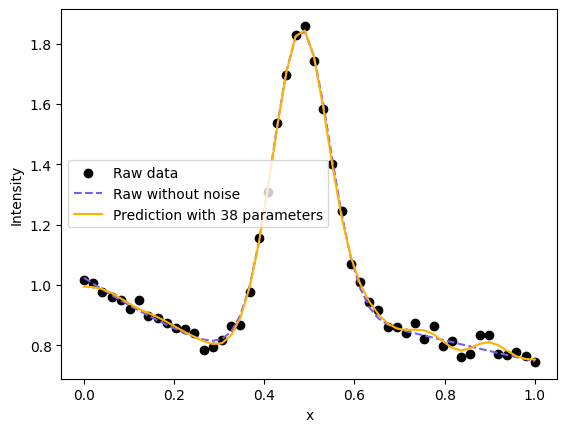

In [28]:
plt.scatter(x,raw,label='Raw data',color='black')
plt.plot(x,background+threshold+signal,label='Raw without noise',ls='--',color=colors1[1])
plt.plot(x,prediction[np.argmin(E_test)],label='Prediction with %d parameters'%(np.argmin(E_test)+1),color=colors1[4])
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()

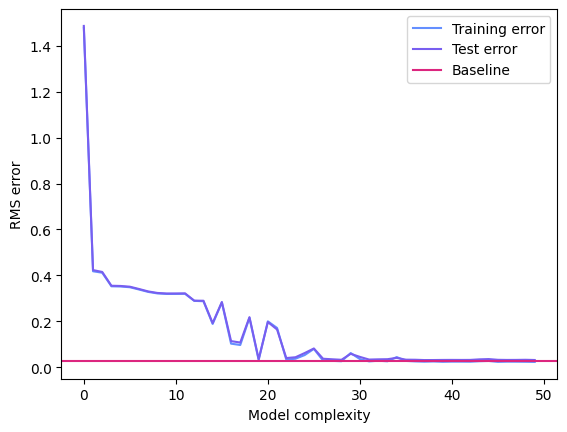

In [29]:
plt.plot(range(M),E,label='Training error',color=colors1[0])
plt.plot(range(M),E_test,label='Test error',color=colors1[1])
plt.axhline(E_baseline,label='Baseline',color=colors1[2])
plt.xlabel('Model complexity')
plt.ylabel('RMS error')
#plt.yscale('log')
plt.legend()

In [30]:
print('The best model is a polynomial of %dth order and has RMS error value %f' %(np.argmin(E_test)+1,np.min(E_test)))

The best model is a polynomial of 38th order and has RMS error value 0.031437
